In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import shap
import warnings

In [2]:
df = pl.read_csv(r'C:\Users\USER\PEF\Terrain-Traversability-Analysis\terrain_features.csv')
df

Xnorm,Ynorm,Znorm,VarZ,Height Z,Median Near IR,Median Signal,Median Reflectivity,Acceleration (REFLECTIVITY %),RANGE (mm),ROW,DESTAGGERED IMAGE COLUMN,Class
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64
-0.024746,-0.005636,0.999678,0.000007,-0.862673,534.5,298.0,104.0,0.5,3070,59,275,0
-0.024746,-0.005636,0.999678,0.000007,-0.859994,534.5,298.0,104.0,-0.5,3027,59,276,0
-0.052566,0.012975,0.998533,0.000014,-0.861733,532.5,295.0,104.0,1.5,2955,60,276,0
-0.057049,-0.022985,0.998107,0.000012,-0.85392,491.5,283.5,102.0,-2.5,2849,61,276,0
-0.019243,-0.021422,0.999585,0.000007,-0.863455,548.0,302.0,104.0,-0.5,3098,58,277,0
…,…,…,…,…,…,…,…,…,…,…,…,…
-0.065442,0.065081,0.995732,0.000015,-0.657796,962.0,492.5,116.5,0.0,2734,55,752,4
-0.05576,0.073553,0.995731,0.00002,-0.665103,933.0,490.5,116.5,-1.0,2679,56,752,4
-0.032017,-0.032788,0.998949,0.000012,-0.649434,950.0,512.0,117.5,-2.5,2940,53,753,4


In [3]:
features_to_remove = [
    'Xnorm',
    'Ynorm', 
    'Znorm',
    'Acceleration (REFLECTIVITY %)'
]

df = df.drop(features_to_remove)

df

VarZ,Height Z,Median Near IR,Median Signal,Median Reflectivity,RANGE (mm),ROW,DESTAGGERED IMAGE COLUMN,Class
f64,f64,f64,f64,f64,i64,i64,i64,i64
0.000007,-0.862673,534.5,298.0,104.0,3070,59,275,0
0.000007,-0.859994,534.5,298.0,104.0,3027,59,276,0
0.000014,-0.861733,532.5,295.0,104.0,2955,60,276,0
0.000012,-0.85392,491.5,283.5,102.0,2849,61,276,0
0.000007,-0.863455,548.0,302.0,104.0,3098,58,277,0
…,…,…,…,…,…,…,…,…
0.000015,-0.657796,962.0,492.5,116.5,2734,55,752,4
0.00002,-0.665103,933.0,490.5,116.5,2679,56,752,4
0.000012,-0.649434,950.0,512.0,117.5,2940,53,753,4


In [4]:
X = df.drop(["Class"])
y = df['Class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y, shuffle=True)

In [6]:
print(y_train.value_counts().sort('Class'))
print(y_test.value_counts().sort('Class'))

shape: (5, 2)
┌───────┬─────────┐
│ Class ┆ count   │
│ ---   ┆ ---     │
│ i64   ┆ u32     │
╞═══════╪═════════╡
│ 0     ┆ 1878665 │
│ 1     ┆ 1835279 │
│ 2     ┆ 1841772 │
│ 3     ┆ 1407480 │
│ 4     ┆ 1985173 │
└───────┴─────────┘
shape: (5, 2)
┌───────┬────────┐
│ Class ┆ count  │
│ ---   ┆ ---    │
│ i64   ┆ u32    │
╞═══════╪════════╡
│ 0     ┆ 331529 │
│ 1     ┆ 323873 │
│ 2     ┆ 325019 │
│ 3     ┆ 248379 │
│ 4     ┆ 350325 │
└───────┴────────┘


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=40, step=4),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.BatchNormalization())

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.05))

    model.add(layers.Dense(5, activation="linear")) # 5 units for 5 classes, softmax activation

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

model_builder(kt.HyperParameters())

<Sequential name=sequential, built=True>

In [9]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     project_name='terrain_classification',
                     overwrite=True
                     )

In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 40, 'step': 4, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.17647058823, batch_size=512, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 04m 07s]
val_accuracy: 0.9493269920349121

Best val_accuracy So Far: 0.965812087059021
Total elapsed time: 00h 44m 35s


In [13]:
print("Best hyperparameters found:")
print(f"- Number of hidden layers: {best_hps.get('num_layers')}")
print(f"- Activation function: {best_hps.get('activation')}")
print(f"- Learning rate: {best_hps.get('lr') if 'lr' in best_hps.values else best_hps.get('learning_rate')}")

# Show units per layer according to the number of layers
for i in range(best_hps.get('num_layers')):
    print(f"- Units in layer {i + 1}: {best_hps.get(f'units_{i}')}")

# If dropout was used as a boolean hyperparameter
if 'dropout' in best_hps.values:
    print(f"- Dropout enabled: {best_hps.get('dropout')}")


Best hyperparameters found:
- Number of hidden layers: 2
- Activation function: tanh
- Learning rate: 0.009152430307506653
- Units in layer 1: 36
- Units in layer 2: 36
- Dropout enabled: False


In [14]:
tuner.results_summary()

Results summary
Results in .\terrain_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
num_layers: 2
units_0: 36
activation: tanh
dropout: False
lr: 0.009152430307506653
units_1: 36
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.965812087059021

Trial 0017 summary
Hyperparameters:
num_layers: 2
units_0: 28
activation: tanh
dropout: True
lr: 0.004260375392883192
units_1: 36
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.9656296968460083

Trial 0024 summary
Hyperparameters:
num_layers: 2
units_0: 28
activation: relu
dropout: False
lr: 0.0013135502932300573
units_1: 32
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.9651205539703369

Trial 0025 summary
Hyperparameters:
num_layers: 2
units_0: 32
activation: relu
dropout: False
lr: 0.0001700786689115504
unit

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

In [16]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.17647058823, batch_size=512, callbacks = [early_stopping, reduce_lr])

Epoch 1/50
14394/14394 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9478 - loss: 0.1373 - val_accuracy: 0.9607 - val_loss: 0.1057 - learning_rate: 0.0092
Epoch 2/50
14394/14394 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9608 - loss: 0.1047 - val_accuracy: 0.9597 - val_loss: 0.1093 - learning_rate: 0.0092
Epoch 3/50
14394/14394 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9625 - loss: 0.1005 - val_accuracy: 0.9650 - val_loss: 0.0944 - learning_rate: 0.0092
Epoch 4/50
14394/14394 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9633 - loss: 0.0986 - val_accuracy: 0.9668 - val_loss: 0.0900 - learning_rate: 0.0092
Epoch 5/50
14394/14394 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9638 - loss: 0.0973 - val_accuracy: 0.9655 - val_loss: 0.0926 - learning_rate: 0.0092
Epoch 6/50
14394/14394 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9642 - loss: 0.0963 - val_accuracy: 0.9664 - val_loss: 0.0906 - learning_rate: 0.0092
Epoch 7/50
14377/14394 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

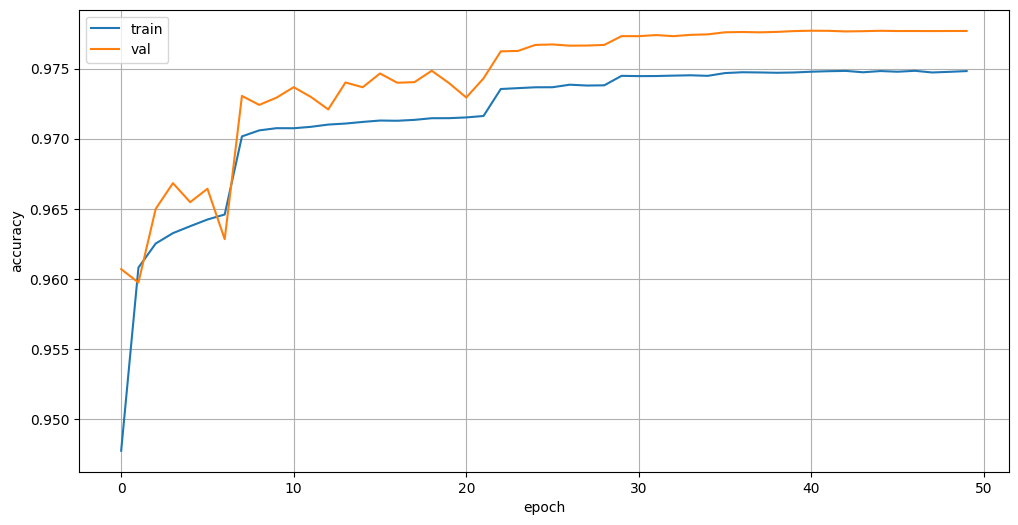

In [17]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.grid()

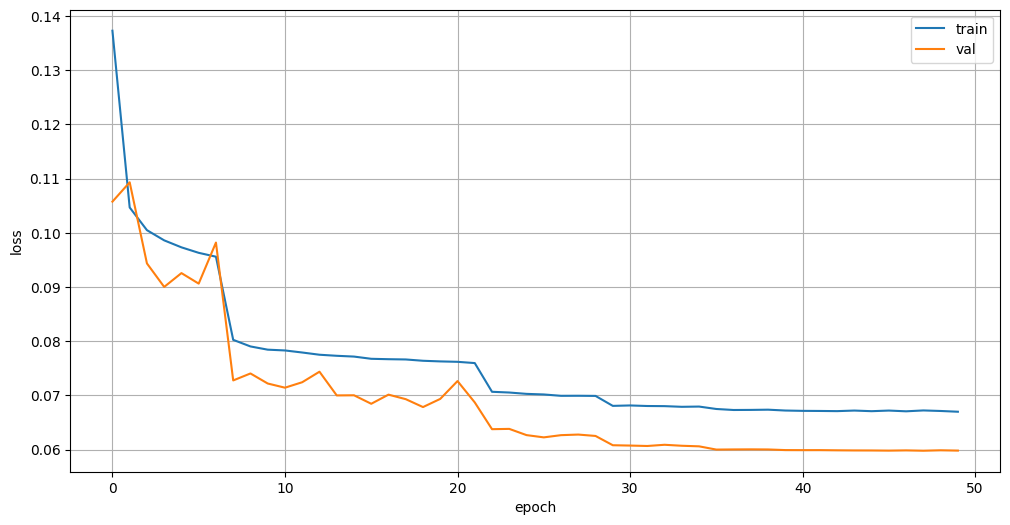

In [18]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.grid()

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 36)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 36)             │         1,332 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,101 (23.84 KB)

 Trainable params: 1,985 (7.75 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 3,972 (15.52 KB)

In [20]:
def check_and_create_directory(directory_path):
    """
    Checks if a directory exists, and if it does not, creates it.

    This function first checks whether the given directory path exists.
    If the directory does not exist, it attempts to create it using `os.makedirs()`.
    If the directory exists, it simply prints a message indicating so.
    If there is an error during directory creation, the exception is caught and an error message is displayed.

    Args:
        directory_path (str): The path of the directory to check and create if not present.

    Returns:
        None
    """

    # Check if the directory already exists
    if not os.path.exists(directory_path):

        try:
            # Create the directory if it does not exist
            os.makedirs(directory_path)
            print(f"Directory '{directory_path}' created.")

        except OSError as error:
            print(f"Error creating directory: {error}")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [21]:
# Create a directory to store the Keras model
check_and_create_directory('models')

# Build the Keras filename
prefix = datetime.now().strftime("%Y-%m-%d-%H-%M-%S-%f")[:-4]
filename = 'terrain-classification-model.keras'
path_and_filename = "".join(['models/', prefix, '-', filename])

# Save the model
model.save(path_and_filename)

Directory 'models' already exists.


In [22]:
new_model = tf.keras.models.load_model(path_and_filename, custom_objects=None, compile=True, safe_mode=True)
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 36)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 36)             │         1,332 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,101 (23.84 KB)

 Trainable params: 1,985 (7.75 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 3,972 (15.52 KB)

In [23]:
# Evaluate the model on the test data
loss, accuracy = new_model.evaluate(X_test, y_test) # Se evalua el modelo con los datos de prueba.
print(f"Test Accuracy: {accuracy:.4f}")

49348/49348 ━━━━━━━━━━━━━━━━━━━━ 42s 854us/step - accuracy: 0.9782 - loss: 0.0589
Test Accuracy: 0.9782


49348/49348 ━━━━━━━━━━━━━━━━━━━━ 28s 557us/step


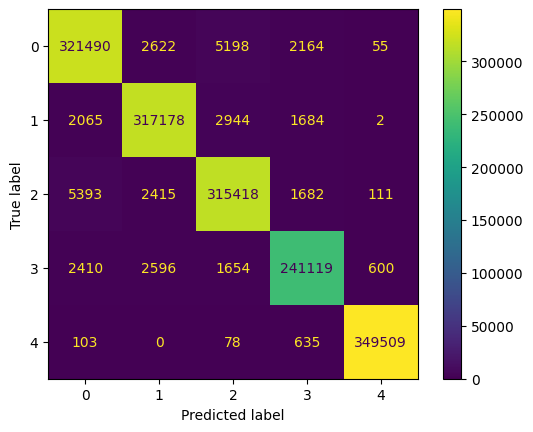

In [24]:
# Realizar las predicciones
y_probabilities = new_model.predict(X_test)

# Convertir las probabilidades en predicciones de clases (índices de la clase con la mayor probabilidad)
y_predictions = np.argmax(y_probabilities, axis=1)

# Calcular la matriz de confusión
c_matrix = confusion_matrix(y_true=y_test, y_pred=y_predictions)

# Mostrar la matriz de confusión
display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
display_matrix.plot()

In [25]:
print(f"\nClasification Report: \n\n{classification_report(y_test, y_predictions)}")


Clasification Report: 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    331529
           1       0.98      0.98      0.98    323873
           2       0.97      0.97      0.97    325019
           3       0.98      0.97      0.97    248379
           4       1.00      1.00      1.00    350325

    accuracy                           0.98   1579125
   macro avg       0.98      0.98      0.98   1579125
weighted avg       0.98      0.98      0.98   1579125



In [26]:
accuracy = accuracy_score(y_test, y_predictions)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_test, y_predictions, average='macro')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test, y_predictions, average='macro')
print(f"Recall: {recall:0.4f}")

f1 = f1_score(y_test, y_predictions, average='macro')
print(f"F1-score: {f1:0.4f}")

Accuracy: 0.9782
Precision: 0.9778
Recall: 0.9776
F1-score: 0.9777


c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_deep\deep_tf.py:153: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn(



Class 0:


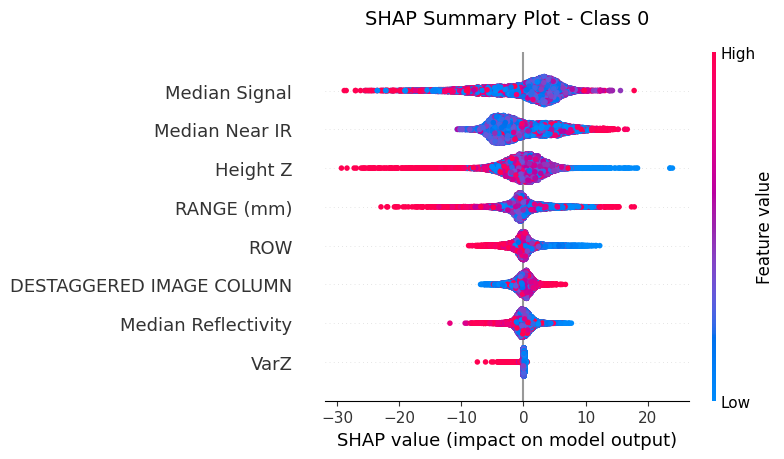

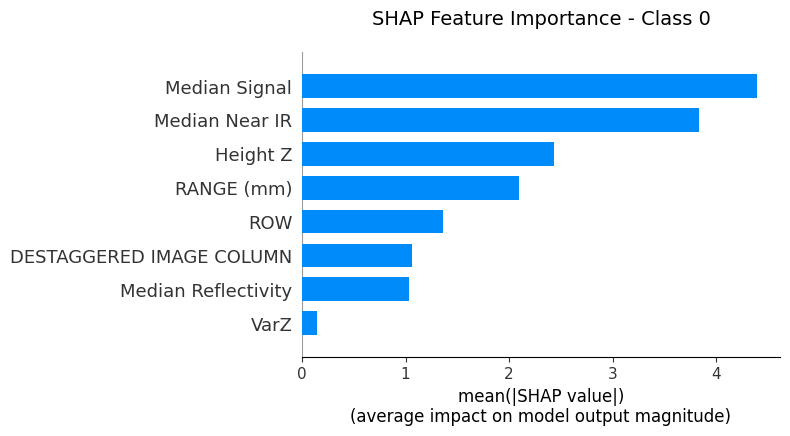


Class 1:


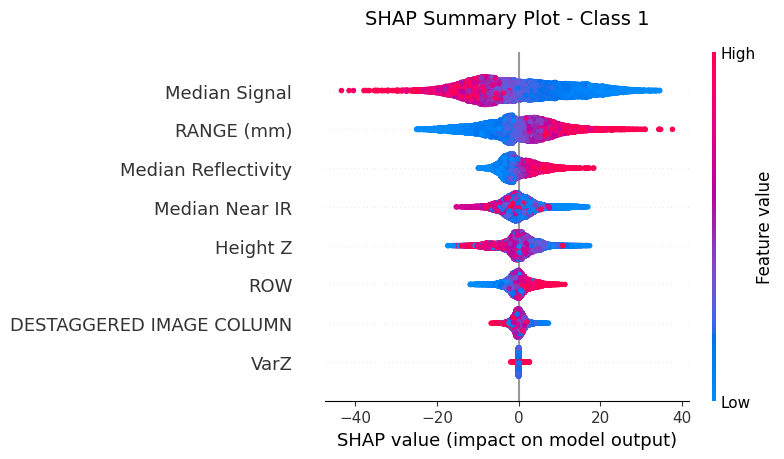

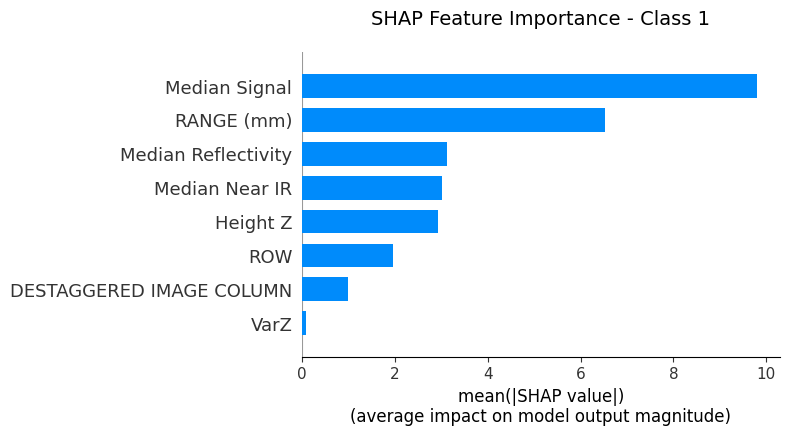


Class 2:


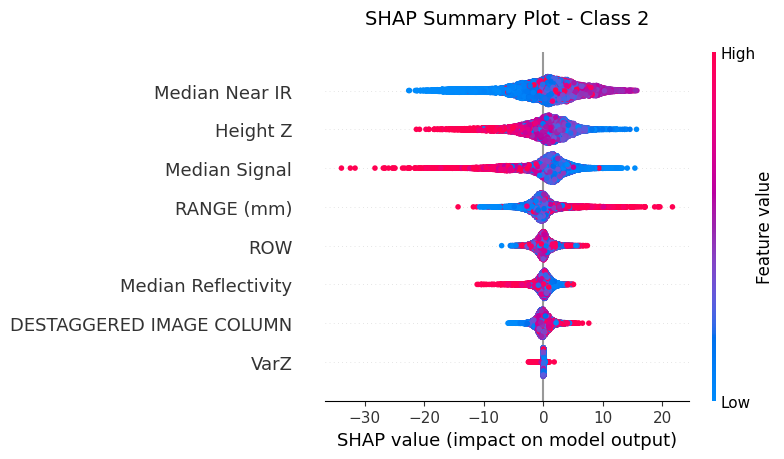

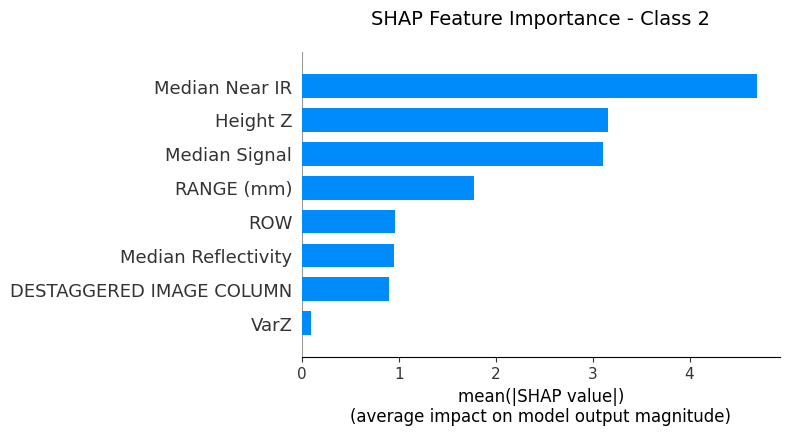


Class 3:


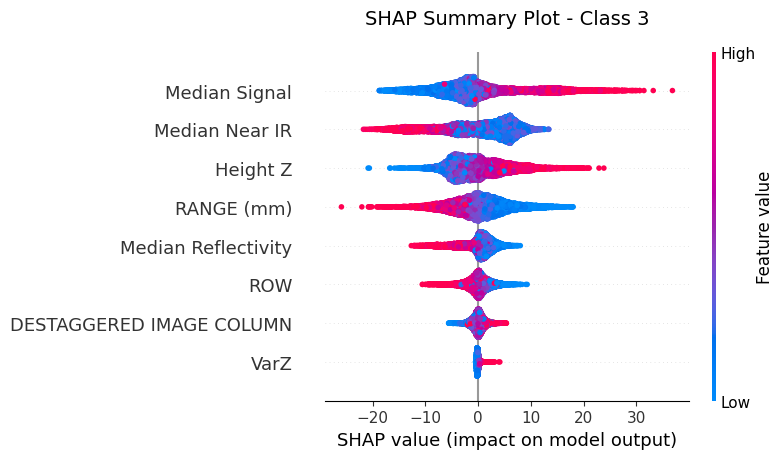

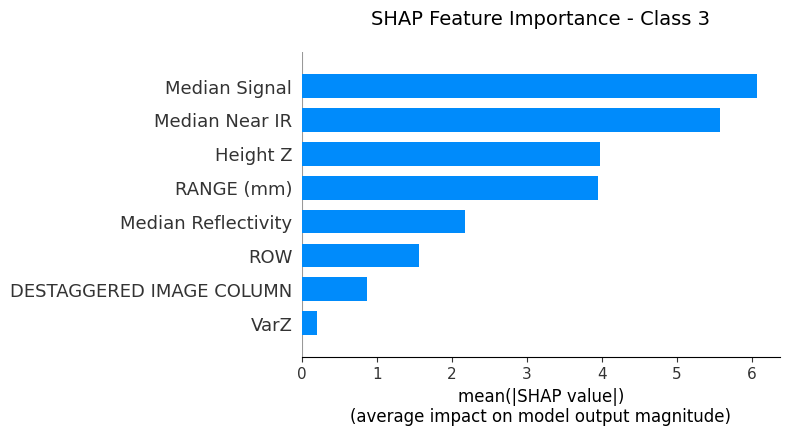


Class 4:


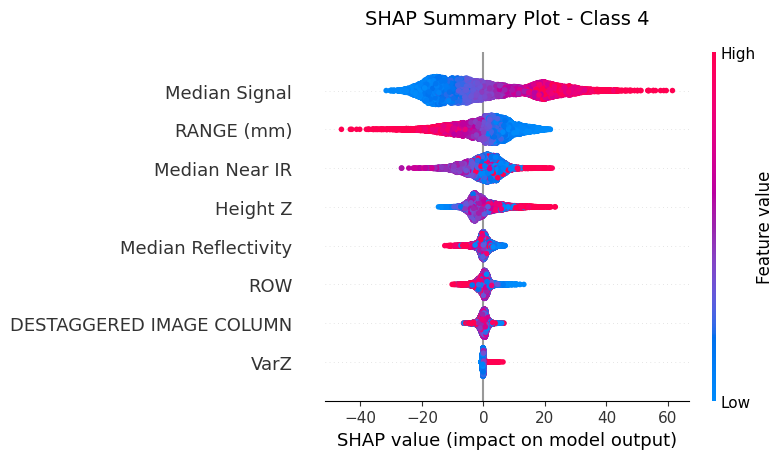

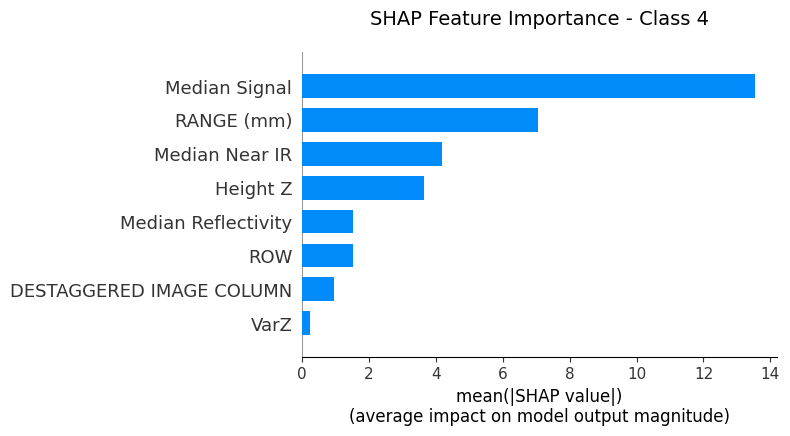

In [31]:
# Suppress Keras user warnings and other future warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')
warnings.filterwarnings('ignore', category=FutureWarning)

X_train_array = X_train
X_test_array = X_test

# 1. BACKGROUND SAMPLE (adjust depending on available RAM; 100-1000 typical)
n_background = 20000
background_indices = np.random.choice(X_train_array.shape[0], n_background, replace=False)
X_background = X_train_array[background_indices]

# 2. CREATE GRADIENT EXPLAINER
explainer = shap.DeepExplainer(model, X_background)

# 3. CALCULATE SHAP VALUES (only for a small subset of the test set)
n_explain = 20000  # how many predictions to explain
X_explain = X_test_array[:n_explain]

shap_values = explainer.shap_values(X_explain)

# IMPORTANT: Multiclass classification
# shap_values shape will be (n_samples, n_features, n_classes)

# For multiclass, SHAP returns values for EACH CLASS
# Example shape: (200, 12, 5) = (samples, features, classes)
n_classes = shap_values.shape[2]

feature_names = df.drop(["Class"]).columns

for i in range(n_classes):
    # OPTION 1: Analyze a specific class (e.g., class 0)
    class_of_interest = i  # change this to inspect other classes
    shap_values_class = shap_values[:, :, class_of_interest]
    print(f"\nClass {class_of_interest}:")

    # ============================================
    # VISUALIZATIONS FOR MULTICLASS EXPLANATIONS
    # ============================================

    # Plot 1: Summary Plot for the class of interest
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_class, X_explain, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot - Class {class_of_interest}', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Plot 2: Bar Plot (feature importance) for the class of interest
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_class, X_explain, feature_names=feature_names,
                      plot_type="bar", show=False, max_display=12)
    plt.title(f'SHAP Feature Importance - Class {class_of_interest}', fontsize=14, pad=20)

    # Improved x-label and layout to make sure bottom text is visible
    plt.xlabel("mean(|SHAP value|)\n(average impact on model output magnitude)", fontsize=12)
    plt.subplots_adjust(bottom=0.25)   # increase bottom margin if the x-label is cut off
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()